##**kMeans Clustering of stocks by return and volatility over previous 30-day period**

BUS 774

C Kaligotla

24 Feb 2025

We analyze the S&P 500 index to cluster stocks based on return and volatility. This index comprises 500 large-cap US companies from various sectors, traded on NYSE or Nasdaq. Due to its representation of the US’s largest publicly traded firms, it serves as a suitable dataset for algorithmic k-means clustering.

Src: https://medium.com/@facujallia/stock-classification-using-k-means-clustering-8441f75363de

### Preamble

Import Libraries

In [1]:
#Import the libraries that we are going to need to carry out the analysis:
import numpy as np
import pandas as pd
import yfinance as yf

from pylab import plot,show
from matplotlib import pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from numpy.random import rand
from scipy.cluster.vq import kmeans,vq
from math import sqrt
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


import warnings
warnings.filterwarnings('ignore')


### Load Data

In [2]:
# Define the url
sp500_url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'

# Read in the url and scrape ticker data
data_table = pd.read_html(sp500_url)
tickers = data_table[0]['Symbol'].values.tolist()
tickers = [s.replace('\n', '') for s in tickers]
tickers = [s.replace('.', '-') for s in tickers]
tickers = [s.replace(' ', '') for s in tickers]
print(tickers)

['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A', 'APD', 'ABNB', 'AKAM', 'ALB', 'ARE', 'ALGN', 'ALLE', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AEE', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'AME', 'AMGN', 'APH', 'ADI', 'ANSS', 'AON', 'APA', 'APO', 'AAPL', 'AMAT', 'APTV', 'ACGL', 'ADM', 'ANET', 'AJG', 'AIZ', 'T', 'ATO', 'ADSK', 'ADP', 'AZO', 'AVB', 'AVY', 'AXON', 'BKR', 'BALL', 'BAC', 'BAX', 'BDX', 'BRK-B', 'BBY', 'TECH', 'BIIB', 'BLK', 'BX', 'BK', 'BA', 'BKNG', 'BWA', 'BSX', 'BMY', 'AVGO', 'BR', 'BRO', 'BF-B', 'BLDR', 'BG', 'BXP', 'CHRW', 'CDNS', 'CZR', 'CPT', 'CPB', 'COF', 'CAH', 'KMX', 'CCL', 'CARR', 'CAT', 'CBOE', 'CBRE', 'CDW', 'CE', 'COR', 'CNC', 'CNP', 'CF', 'CRL', 'SCHW', 'CHTR', 'CVX', 'CMG', 'CB', 'CHD', 'CI', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'CL', 'CMCSA', 'CAG', 'COP', 'ED', 'STZ', 'CEG', 'COO', 'CPRT', 'GLW', 'CPAY', 'CTVA', 'CSGP', 'COST', 'CTRA', 'CRWD', 'CCI', 'CSX', 'CMI', 'CVS', 'DHR', 'DRI', 'DV

Note1: Pandas datareader does not support yahoo finance anymore. use yahoofinance directly

Note2: There is no Adj Close on yfinance.

  use auto_adjust=True, actions=True

  See https://github.com/ranaroussi/yfinance/issues/1749 and https://github.com/ranaroussi/yfinance/issues/1749
  
  Also refer yfinance documentation here: https://github.com/ranaroussi/yfinance/wiki/Ticker#parameters


In [ ]:
# Testing Yahoo Call
#p = yf.Ticker('ADBE')
#p2 = p.history(start='2025-01-23',end='2025-02-23', auto_adjust=True, actions=True)['Close']
#print(p2.head())

In [5]:
# Download prices
prices_list = []
for ticker in tickers:
    try:
        data = yf.Ticker(ticker)
        prices = data.history(start='2025-01-23',end='2025-02-23', auto_adjust=True, actions=True)['Close']
        prices = pd.DataFrame(prices)
        prices.columns = [ticker]
        prices_list.append(prices)
    except:
        pass
    prices_df = pd.concat(prices_list,axis=1)
prices_df.sort_index(inplace=True)

ERROR:yfinance:Could not get exchangeTimezoneName for ticker 'ETR' reason: 'chart'
ERROR:yfinance:$ETR: possibly delisted; no timezone found
ERROR:yfinance:Could not get exchangeTimezoneName for ticker 'LEN' reason: 'chart'
ERROR:yfinance:$LEN: possibly delisted; no timezone found


In [6]:
prices_df

,MMM,AOS,ABT,ABBV,ACN,ADBE,AMD,AES,AFL,A,...,WMB,WTW,WDAY,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2025-01-23 00:00:00-05:00,149.630005,70.909996,123.220001,170.669998,363.260010,437.279999,123.040001,11.349939,104.470001,152.449997,...,59.490002,319.000000,255.300003,85.080002,66.059998,121.580002,127.010002,421.109985,111.010002,166.960007
2025-01-24 00:00:00-05:00,149.429993,70.213531,125.029999,170.300003,362.410004,435.380005,122.839996,11.418847,104.910004,151.440002,...,59.570000,322.369995,258.279999,84.989998,66.610001,121.570000,128.259995,414.609985,110.809998,168.610001
2025-01-27 00:00:00-05:00,151.520004,71.069191,129.429993,176.899994,373.149994,438.600006,115.010002,11.261345,108.150002,150.960007,...,54.549999,329.440002,264.200012,84.769997,67.989998,122.180000,130.889999,399.359985,112.580002,173.029999
2025-01-28 00:00:00-05:00,151.399994,69.517075,127.389999,174.809998,378.390015,442.839996,114.169998,10.838060,107.279999,150.339996,...,55.200001,326.070007,270.429993,84.330002,66.430000,121.339996,129.240005,405.589996,111.860001,170.419998
2025-01-29 00:00:00-05:00,151.539993,68.870354,127.860001,175.259995,374.420013,441.679993,117.349998,10.975874,107.620003,147.089996,...,55.330002,324.540009,265.399994,84.110001,66.070000,121.250000,129.169998,399.589996,111.050003,170.220001
2025-01-30 00:00:00-05:00,154.399994,66.970001,128.809998,175.649994,380.750000,446.000000,118.860001,11.094001,108.250000,151.380005,...,56.590000,329.829987,260.070007,89.599998,66.860001,121.790001,130.729996,394.700012,110.620003,172.710007
2025-01-31 00:00:00-05:00,152.199997,67.300003,127.930000,183.899994,384.950012,437.450012,115.949997,11.000000,107.379997,151.520004,...,55.430000,329.570007,262.059998,86.849998,67.199997,124.040001,130.500000,391.940002,109.480003,170.899994
2025-02-03 00:00:00-05:00,150.039993,67.040001,128.449997,190.139999,385.209991,438.600006,114.269997,10.710000,106.709999,148.630005,...,56.200001,330.670013,259.769989,83.559998,67.750000,122.800003,131.500000,386.089996,108.160004,171.940002
2025-02-04 00:00:00-05:00,151.679993,65.660004,129.100006,189.949997,391.619995,440.230011,119.500000,10.610000,106.760002,147.039993,...,55.720001,320.309998,259.730011,83.190002,67.320000,129.240005,131.470001,383.459991,107.800003,172.240005


In [7]:
# Create an empty dataframe for raw returns, log returns, and daily volatility
returns = pd.DataFrame()

# Calculate annualized average return for each ticker
returns['Returns'] = prices_df.pct_change().mean() * 252
  # Note:
    # prices_df.pct_change(): Calculates the percentage change between consecutive prices in the prices_df DataFrame, giving you daily returns.
    #.mean(): Calculates the average of the daily returns.
    # * 252: Annualizes the average daily return by multiplying it by the approximate number of trading days in a year.

# Calculate annualized volatility of daily return for each ticker
returns['Volatility'] = prices_df.pct_change().std() * sqrt(252)
 # Note:
   # prices_df.pct_change(): Calculates the percentage change between consecutive prices in the prices_df DataFrame, giving you daily returns.
   # .std(): Calculates the standard deviation of the daily returns, a measure of their variability.
   # * sqrt(252): Annualizes the daily volatility by multiplying it by the square root of the approximate number of trading days in a year.


In [8]:
returns

,Returns,Volatility
MMM,-0.383066,0.173721
AOS,-0.886945,0.201728
ABT,1.169744,0.225917
ABBV,2.166152,0.247766
ACN,0.073793,0.284909
...,...,...
XYL,0.610678,0.239618
YUM,2.064940,0.382400
ZBRA,-3.717062,0.382446
ZBH,-0.692938,0.239529


### Fitting K-Means Classifier : Data preprocessing into an array

In [13]:
# Format the data as a numpy array to feed into the K-Means algorithm
data = np.asarray([np.asarray(returns['Returns']),np.asarray(returns['Volatility'])]).T
X = data

# Before fitting the KMeans model, handle NaN values in X
X = np.nan_to_num(X)  # Replace NaN with 0 and infinity with large finite numbers

print(X)

[[-0.38306612  0.17372109]
 [-0.88694547  0.20172848]
 [ 1.16974379  0.22591732]
 ...
 [-3.71706162  0.38244626]
 [-0.69293759  0.23952884]
 [-0.45281921  0.31204437]]


### Fitting K-Means Classifier : Identifying ideal number of clusters

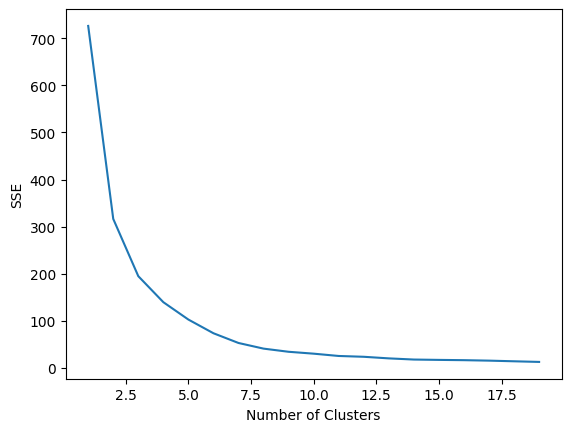

In [14]:
sse = [] # also called distortions
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)
plt.plot(range(1, 20), sse)
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.show()

In [15]:
print(sse)

[726.0377199831131, 316.56632846121533, 195.067909544003, 139.87769347793454, 103.00827044067309, 73.98089753826784, 53.32155900455885, 41.358972139695275, 34.66658174258156, 30.647095658431617, 25.767362575478966, 24.044746825533448, 20.662185271839967, 18.183757769654466, 17.442081231036294, 16.851892214415564, 15.867697679423815, 14.49029169994495, 13.143235425610522]


**Looks like k==7 will do**

### Fitting K-Means Classifier with k=7

In [16]:
# fit k-means model with optimal number of clusters
K = 7  # Number of clusters chosen from elbow methid
#Todo: play around with say k=9?

kmeans = KMeans(n_clusters=K, random_state=42)
kmeans.fit(X)


KMeans(n_clusters=7, random_state=42)

### Compute Centroids and prepare output

In [19]:
# Computing K-Means with K  clusters
centroids = kmeans.cluster_centers_

# Replace infs and NaNs in 'data' with finite values
data = np.nan_to_num(data)

# Assign each sample to a cluster
idx,_ = vq(data,centroids)

# Create a dataframe with the tickers and the clusters that's belong to
details = [(name,cluster) for name, cluster in zip(returns.index,idx)]
details_df = pd.DataFrame(details)

# Rename columns
details_df.columns = ['Ticker','Cluster']

# Create another dataframe with the tickers and data from each stock
clusters_df = returns.reset_index()

# Bring the clusters information from the dataframe 'details_df'
clusters_df['Cluster'] = details_df['Cluster']

# Create a DataFrame for centroids
centroids_df = pd.DataFrame(centroids, columns=['Returns', 'Volatility'])
centroids_df['Cluster'] = range(K)  # Assign a cluster label to each centroid

# Rename columns
clusters_df.columns = ['Ticker', 'Returns', 'Volatility', 'Cluster']

In [20]:
# See the table output of clustering tickers
clusters_df
# To see a specific cluster use:clusters_df[clusters_df['Cluster']==1]

,Ticker,Returns,Volatility,Cluster
0,MMM,-0.383066,0.173721,0
1,AOS,-0.886945,0.201728,6
2,ABT,1.169744,0.225917,5
3,ABBV,2.166152,0.247766,1
4,ACN,0.073793,0.284909,0
...,...,...,...,...
498,XYL,0.610678,0.239618,5
499,YUM,2.064940,0.382400,1
500,ZBRA,-3.717062,0.382446,2
501,ZBH,-0.692938,0.239529,6


### **K-Means Cluster Visualization**

In [21]:
# Plot the clusters created using Plotly
fig = px.scatter(clusters_df, x="Returns", y="Volatility", color="Cluster", hover_data=["Ticker"])
#Add centroids to the scatter plot
fig.add_trace(go.Scatter(
    x=centroids_df['Returns'],
    y=centroids_df['Volatility'],
    mode='markers+text',
    marker=dict(color='black', size=15, symbol='x'),
    text=centroids_df['Cluster'],
    textposition='top center',
    name='Centroids'
))
#fig.update(layout_coloraxis_showscale=False)
fig.update_layout(coloraxis_showscale=False, height=800) # Update the layout to set height
fig.show()

In [22]:
# To see list of tickers in each cluster use
## clusters_df[clusters_df['Cluster']==1]

#### **Output 1 and 2:**
1. Group by cluster and show select statistics
2. Show cluster membership

In [23]:
# Group the DataFrame by 'Cluster' and aggregate the desired statistics
cluster_summary = clusters_df.groupby('Cluster').agg(
    Avg_Return=('Returns', 'mean'),
    Avg_Volatility=('Volatility', 'mean'),
    Num_Tickers=('Ticker', 'count')
).reset_index()

# Calculate the return to volatility ratio
cluster_summary['Return_Volatility_Ratio'] = cluster_summary['Avg_Return'] / cluster_summary['Avg_Volatility']

# Print the list of tickers per cluster
for cluster in clusters_df['Cluster'].unique():
    print(f"\nTickers in Cluster {cluster}:")
    print(clusters_df[clusters_df['Cluster'] == cluster]['Ticker'].tolist())


# Print the summary table
cluster_summary


Tickers in Cluster 0:
['MMM', 'ACN', 'ADBE', 'AFL', 'ALL', 'AME', 'APA', 'AIZ', 'AZO', 'AVB', 'BKR', 'BIIB', 'BA', 'BR', 'BF-B', 'COF', 'CAH', 'KMX', 'COR', 'CRL', 'SCHW', 'CHTR', 'CVX', 'CB', 'CHD', 'CI', 'CINF', 'C', 'CLX', 'CL', 'CMCSA', 'STZ', 'CPRT', 'CTVA', 'CMI', 'DXCM', 'DFS', 'DOV', 'ENPH', 'ETR', 'EOG', 'EQIX', 'ERIE', 'EXPD', 'XOM', 'FDS', 'FAST', 'FRT', 'FITB', 'FTV', 'GE', 'GEN', 'GIS', 'GS', 'HIG', 'HCA', 'HES', 'HWM', 'ITW', 'INCY', 'PODD', 'ISRG', 'IVZ', 'JBHT', 'JKHY', 'JPM', 'K', 'KEY', 'KEYS', 'KLAC', 'LH', 'LEN', 'L', 'LYB', 'MTB', 'MPC', 'MAR', 'MTCH', 'MCK', 'MDT', 'NDAQ', 'NTAP', 'NFLX', 'NWSA', 'NDSN', 'NSC', 'NRG', 'OXY', 'ON', 'OTIS', 'PANW', 'PH', 'PFE', 'PCG', 'PLD', 'RTX', 'REGN', 'ROK', 'RCL', 'SLB', 'SOLV', 'SWK', 'STT', 'STE', 'SYK', 'SYY', 'TEL', 'TFX', 'TXN', 'TJX', 'TSCO', 'TRV', 'TFC', 'UNP', 'VLO', 'VTRS', 'WMT', 'DIS', 'WFC', 'WDC', 'WY', 'WMB', 'WTW', 'WDAY']

Tickers in Cluster 6:
['AOS', 'AMD', 'AES', 'APD', 'ALB', 'ARE', 'ALLE', 'GOOGL', 'GOOG

,Cluster,Avg_Return,Avg_Volatility,Num_Tickers,Return_Volatility_Ratio
0,0,-0.038269,0.263193,124,-0.145404
1,1,1.750967,0.368146,44,4.756169
2,2,-3.544278,0.828552,11,-4.277675
3,3,-1.791442,0.421947,64,-4.245657
4,4,7.396663,1.303005,1,5.676620
5,5,0.722843,0.257901,131,2.802792
6,6,-0.779267,0.304735,128,-2.557195


 #### **Output 3:**
 Plot and Compare Avg Annualized Returns and Volatility distributions for each cluster

In [25]:


# Create a new figure with subplots
fig = make_subplots(rows=K, cols=2,
                    subplot_titles=("Cluster 0 - Returns", "Cluster 0 - Volatility",
                                    "Cluster 1 - Returns", "Cluster 1 - Volatility",
                                    "Cluster 2 - Returns", "Cluster 2 - Volatility",
                                    "Cluster 3 - Returns", "Cluster 3 - Volatility",
                                    "Cluster 4 - Returns", "Cluster 4 - Volatility",
                                    "Cluster 5 - Returns", "Cluster 5 - Volatility",
                                    "Cluster 6 - Returns", "Cluster 6 - Volatility"))

# Loop through each cluster and create a histogram for returns and volatility
for i, cluster in enumerate(clusters_df['Cluster'].unique()):
    cluster_data = clusters_df[clusters_df['Cluster'] == cluster]

    # Create a histogram for returns
    # Use i+1 to start from row 1
    fig.add_trace(go.Histogram(x=cluster_data['Returns'], name='Returns'), row=i + 1, col=1)
    fig.update_xaxes(range=[-1, 1.6], row=i + 1, col=1) # Set range for x-axis of returns histogram
    fig.update_yaxes(range=[0, 20], row=i + 1, col=1) # Set range for y-axis of returns histogram

    # Create a histogram for volatility
    fig.add_trace(go.Histogram(x=cluster_data['Volatility'], name='Volatility'), row=i + 1, col=2)
    fig.update_xaxes(range=[0, 1], row=i + 1, col=2) # Set range for x-axis of volatility histogram
    fig.update_yaxes(range=[0, 30], row=i + 1, col=2) # Set range for y-axis of returns histogram

# Update the layout
fig.update_layout(height= 1200,width=800, showlegend=False)

# Display the figure
fig.show()